# Risk Based Access Control : Machine Learning for Identity Threat Detection v2

In [250]:
RANDOM_STATE = 42

## Loading and renaming data

In [251]:
import pandas as pd


In [252]:
import pandas as pd

chunk_size = 1000000
chunks = []
sample_fraction_majority = 0.01
sample_fraction_minority = 1
RANDOM_STATE = 42

for i, chunk in enumerate(pd.read_csv("data/rba-dataset.csv", chunksize=chunk_size)):
    minority_class = chunk[chunk["Is Account Takeover"] == True]
    majority_class = chunk[chunk["Is Account Takeover"] == False]

    sampled_minority = minority_class.sample(frac=sample_fraction_minority, random_state=RANDOM_STATE)
    sampled_majority = majority_class.sample(frac=sample_fraction_majority, random_state=RANDOM_STATE)

    combined_sample = pd.concat([sampled_minority, sampled_majority], axis=0)
    chunks.append(combined_sample)

    print(f"chunk {i} processed")

data = pd.concat(chunks, axis=0)

data = data.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

data.head()

chunk 0 processed
chunk 1 processed
chunk 2 processed
chunk 3 processed
chunk 4 processed
chunk 5 processed
chunk 6 processed
chunk 7 processed
chunk 8 processed
chunk 9 processed
chunk 10 processed
chunk 11 processed
chunk 12 processed
chunk 13 processed
chunk 14 processed
chunk 15 processed
chunk 16 processed
chunk 17 processed
chunk 18 processed
chunk 19 processed
chunk 20 processed
chunk 21 processed
chunk 22 processed
chunk 23 processed
chunk 24 processed
chunk 25 processed
chunk 26 processed
chunk 27 processed
chunk 28 processed
chunk 29 processed
chunk 30 processed
chunk 31 processed


,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,NaN,51.175.224.92,NO,Oslo County,Oslo,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.21,Mac OS X 10.14.6,desktop,False,False,False
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,490.0,80.232.87.86,NO,Oslo County,Oslo,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,True,False,False
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,NaN,84.234.232.132,NO,Rogaland,Hommersak,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox 20.0.0.1602,iOS 11.2.6,mobile,False,False,False
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,NaN,185.19.116.76,PL,Łódź Voivodeship,Radomsko,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 79.0.3945.192.201,Chrome OS 5978.98.0,desktop,False,False,False
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,NaN,10.0.181.224,CH,-,-,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 72.0.3626.82,Mac OS X 11.6.3,desktop,False,False,False


### Renaming our column

In [253]:
new_names = {
    "Login Timestamp": "timestamp",
    "User ID": "id",
    "Round-Trip Time [ms]": "rtt_ms",
    "IP Address": "ip",
    "Country": "country",
    "Region": "region",
    "City": "city",
    "ASN": "asn",
    "User Agent String": "user_agent",
    "Browser Name and Version": "browser",
    "OS Name and Version": "os",
    "Device Type": "device",
    "Login Successful": "login_success",
    "Is Attack IP": "is_attack_ip",
    "Is Account Takeover": "is_account_takeover"
}

data.rename(columns=new_names, inplace=True)
data


,index,timestamp,id,rtt_ms,ip,country,region,city,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,NaN,51.175.224.92,NO,Oslo County,Oslo,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.21,Mac OS X 10.14.6,desktop,False,False,False
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,490.0,80.232.87.86,NO,Oslo County,Oslo,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,True,False,False
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,NaN,84.234.232.132,NO,Rogaland,Hommersak,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox 20.0.0.1602,iOS 11.2.6,mobile,False,False,False
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,NaN,185.19.116.76,PL,Łódź Voivodeship,Radomsko,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 79.0.3945.192.201,Chrome OS 5978.98.0,desktop,False,False,False
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,NaN,10.0.181.224,CH,-,-,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 72.0.3626.82,Mac OS X 11.6.3,desktop,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,NaN,10.1.43.51,BR,Rio de Janeiro,Rio de Janeiro,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1937,iOS 13.4,mobile,False,False,False
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,NaN,10.4.138.195,DE,North Rhine-Westphalia,Düsseldorf,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,False,False
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,NaN,10.0.106.46,IN,-,-,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1929,iOS 11.2.6,mobile,False,False,False
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,NaN,10.0.181.225,BR,-,-,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 84.0.4147.338.339,Mac OS X 11.6.3,desktop,False,False,False


# Data Exploration

In [254]:
import matplotlib.pyplot as plt
# %matplotlib inline

In [255]:
data.tail(10)

,index,timestamp,id,rtt_ms,ip,country,region,city,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover
312824,8457040,2020-05-30 10:17:19.342,1927013824574845948,542.0,81.166.201.237,NO,Oslo County,Oslo,29695,Mozilla/5.0 (Linux; U; Android 4.0.3; nb-no; ...,Opera Mobile 52.1.2254.2306,Android 4.0.3,mobile,True,False,False
312825,13008658,2020-08-01 20:53:29.460,5807607246569587389,NaN,187.62.57.204,BR,Parana,Londrina,22689,Mozilla/5.0 (X11; Linux armv7l) AppleWebKit/5...,Chrome 72.0.3626.52,Chromecast 1.49.230269,desktop,True,False,False
312826,5312784,2020-04-15 18:53:03.209,4035502347474917449,NaN,80.203.188.127,NO,-,-,15659,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_...,Chrome 73.0.3654,Mac OS X 10.14.6,desktop,True,False,False
312827,20504225,2020-11-11 19:12:33.898,-4324475583306591935,NaN,80.239.19.95,NO,Rogaland,Naerbo,25400,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox 20.0,iOS 13.4,mobile,False,False,False
312828,11455031,2020-07-10 15:58:49.975,2539586398342197044,670.0,84.209.16.189,NO,Oslo County,Oslo,41164,Mozilla/5.0 (Linux; Android 6.9; SM-J500H/DS ...,Android 2.3.4,Android 6.9,tablet,False,False,False
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,NaN,10.1.43.51,BR,Rio de Janeiro,Rio de Janeiro,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1937,iOS 13.4,mobile,False,False,False
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,NaN,10.4.138.195,DE,North Rhine-Westphalia,Düsseldorf,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,False,False
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,NaN,10.0.106.46,IN,-,-,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1929,iOS 11.2.6,mobile,False,False,False
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,NaN,10.0.181.225,BR,-,-,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 84.0.4147.338.339,Mac OS X 11.6.3,desktop,False,False,False
312833,12353213,2020-07-23 08:30:33.866,-2540757603276050441,NaN,84.208.57.5,NO,Oslo County,Oslo,41164,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.20,Mac OS X 10.14.6,desktop,True,False,False


In [256]:
data.dtypes

index                    int64
timestamp               object
id                       int64
rtt_ms                 float64
ip                      object
country                 object
region                  object
city                    object
asn                      int64
user_agent              object
browser                 object
os                      object
device                  object
login_success             bool
is_attack_ip              bool
is_account_takeover       bool
dtype: object

In [257]:
data.count()

index                  312834
timestamp              312834
id                     312834
rtt_ms                  12740
ip                     312834
country                312834
region                 312352
city                   312730
asn                    312834
user_agent             312834
browser                312834
os                     312834
device                 312820
login_success          312834
is_attack_ip           312834
is_account_takeover    312834
dtype: int64

### Agent Data (OS, Device and Browser)

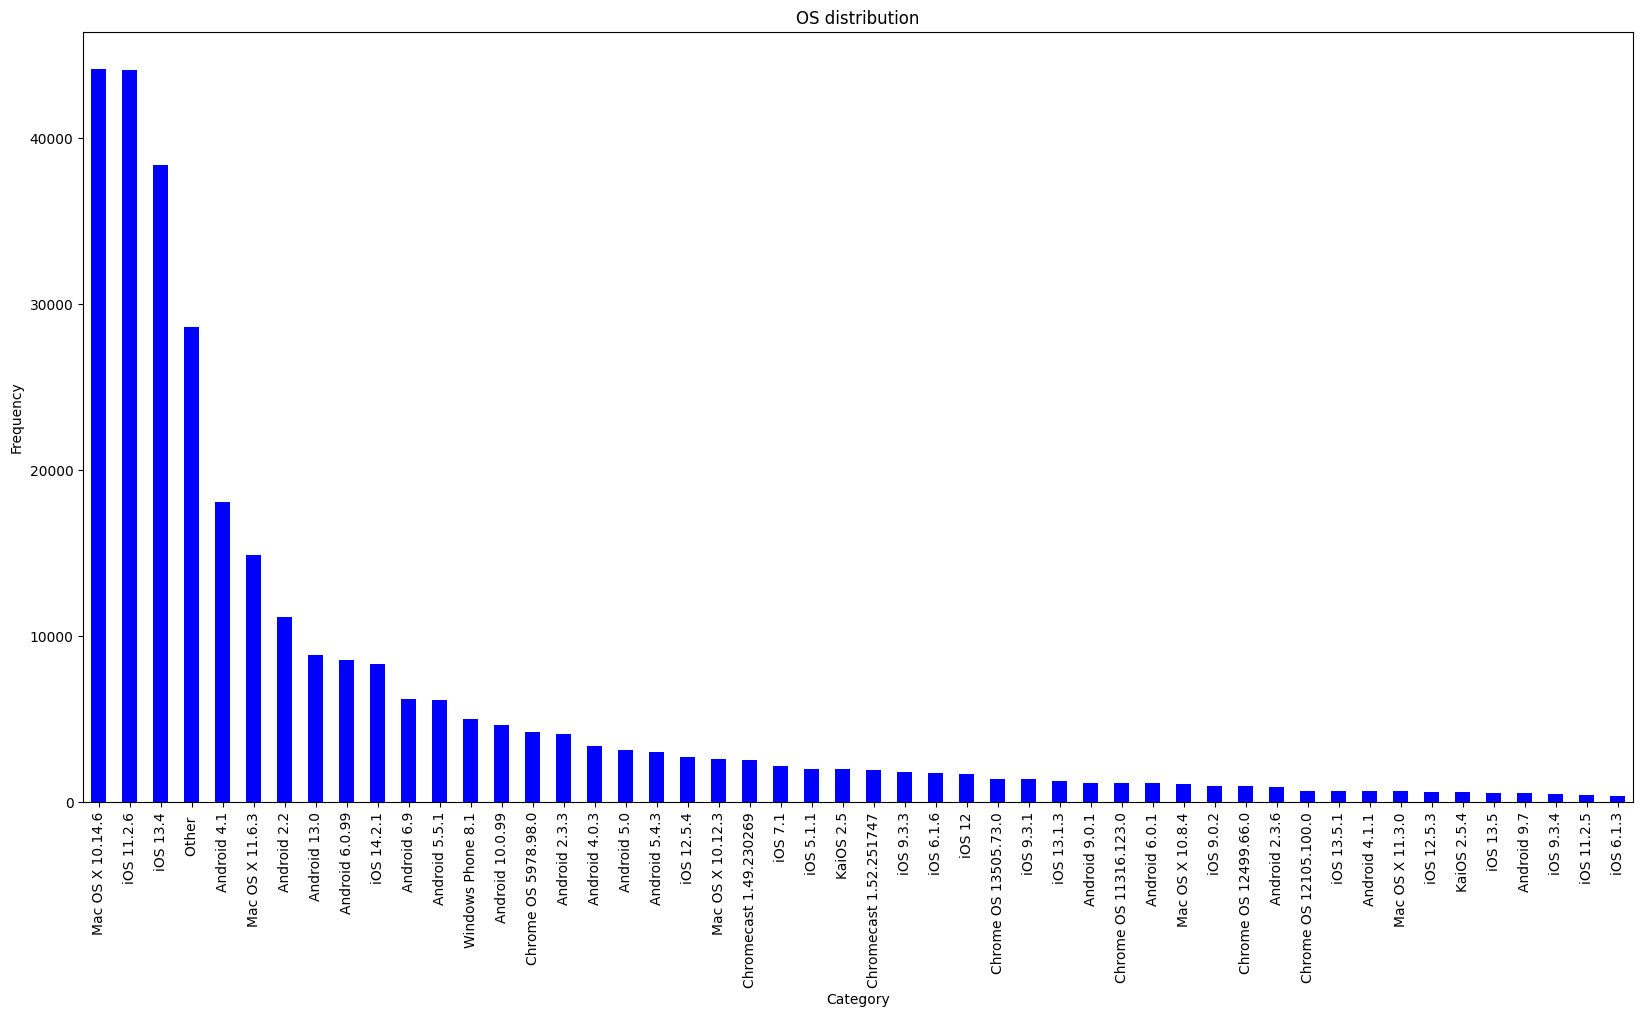

In [258]:
category_counts = data["os"].value_counts().head(50)
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='blue')
plt.title('OS distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

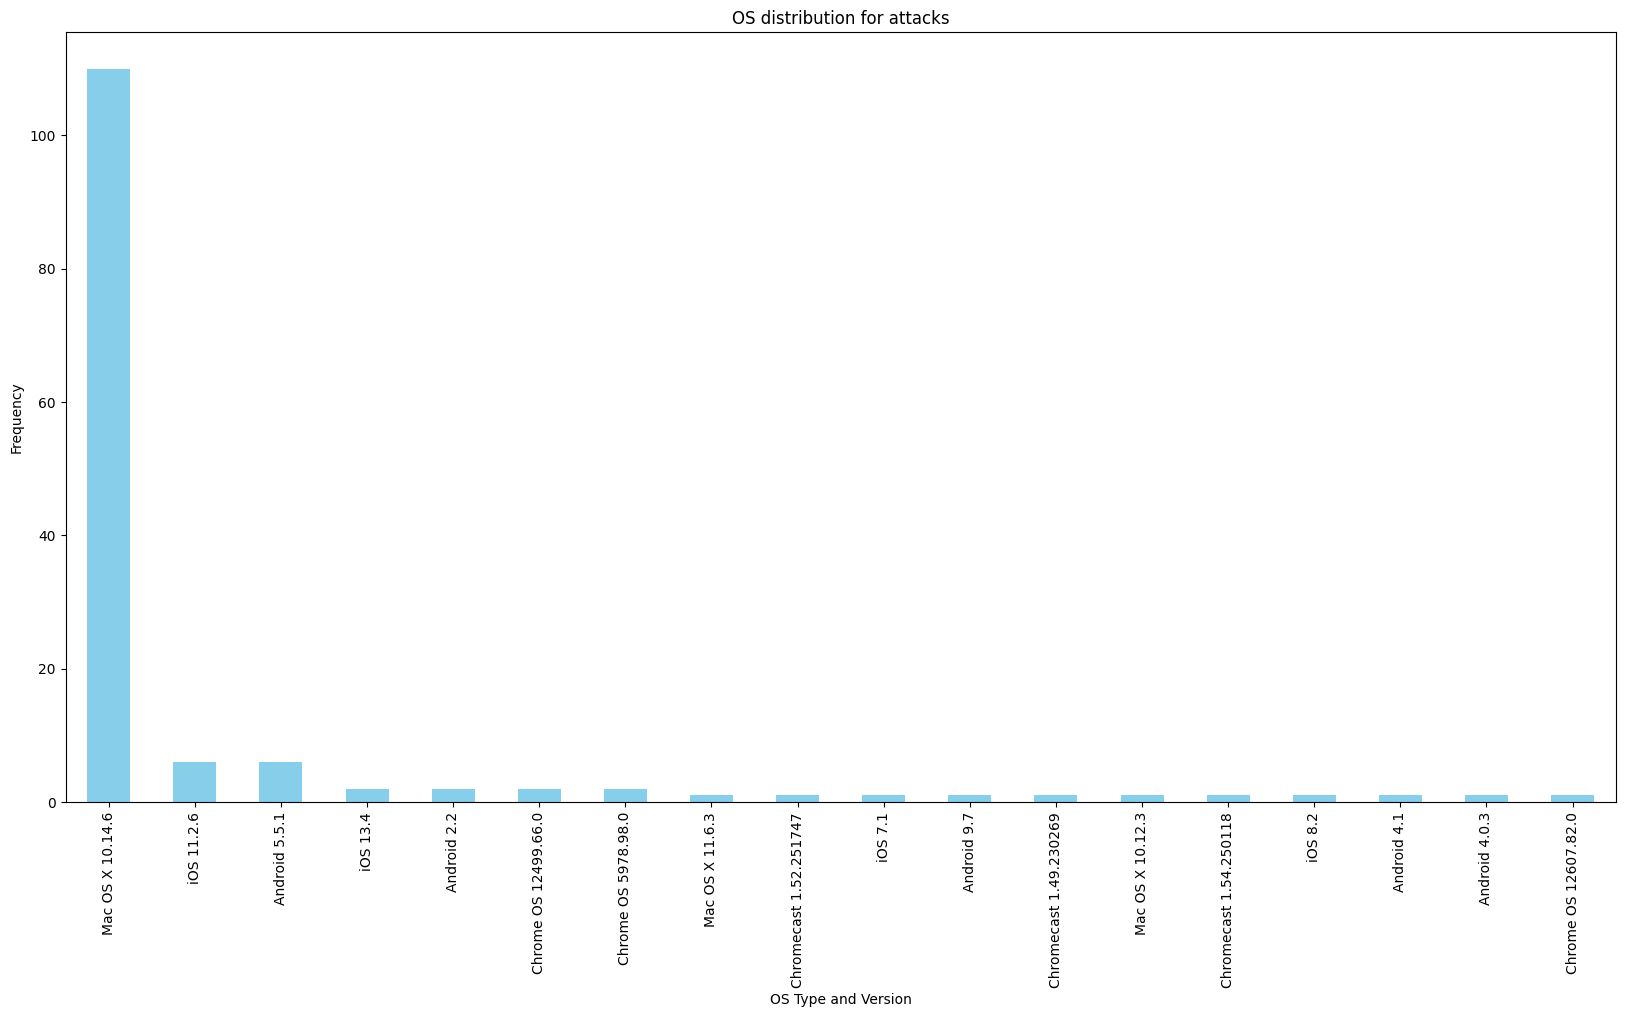

In [259]:
category_counts = data[data['is_account_takeover']==True]["os"].value_counts()
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='skyblue')
plt.title('OS distribution for attacks')
plt.xlabel('OS Type and Version')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

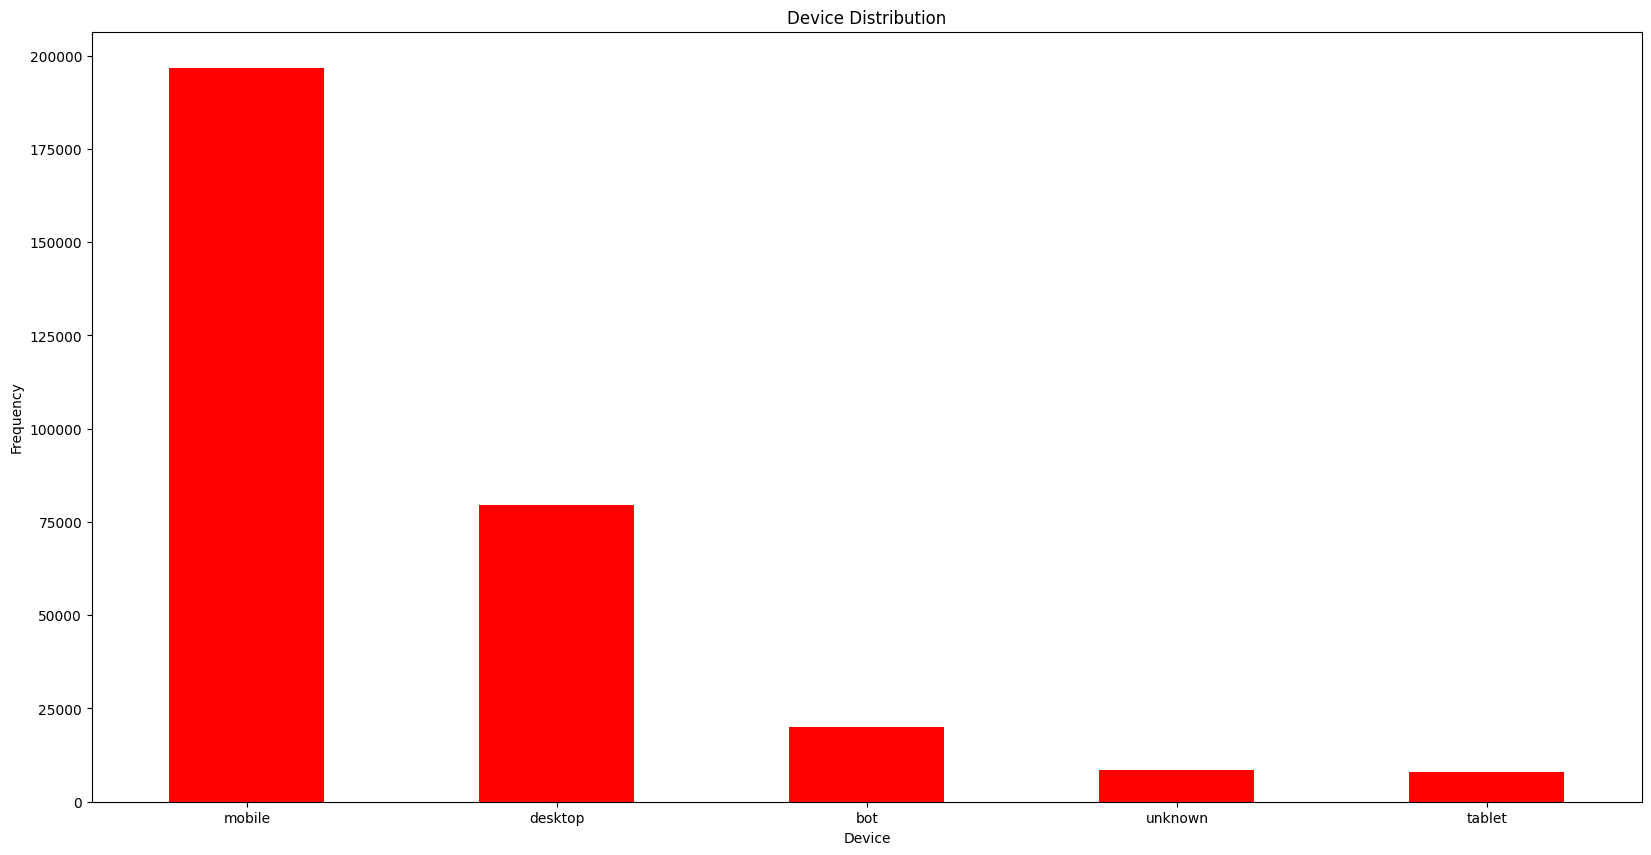

In [260]:
category_counts = data["device"].value_counts()
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='red')
plt.title('Device Distribution')
plt.xlabel('Device')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

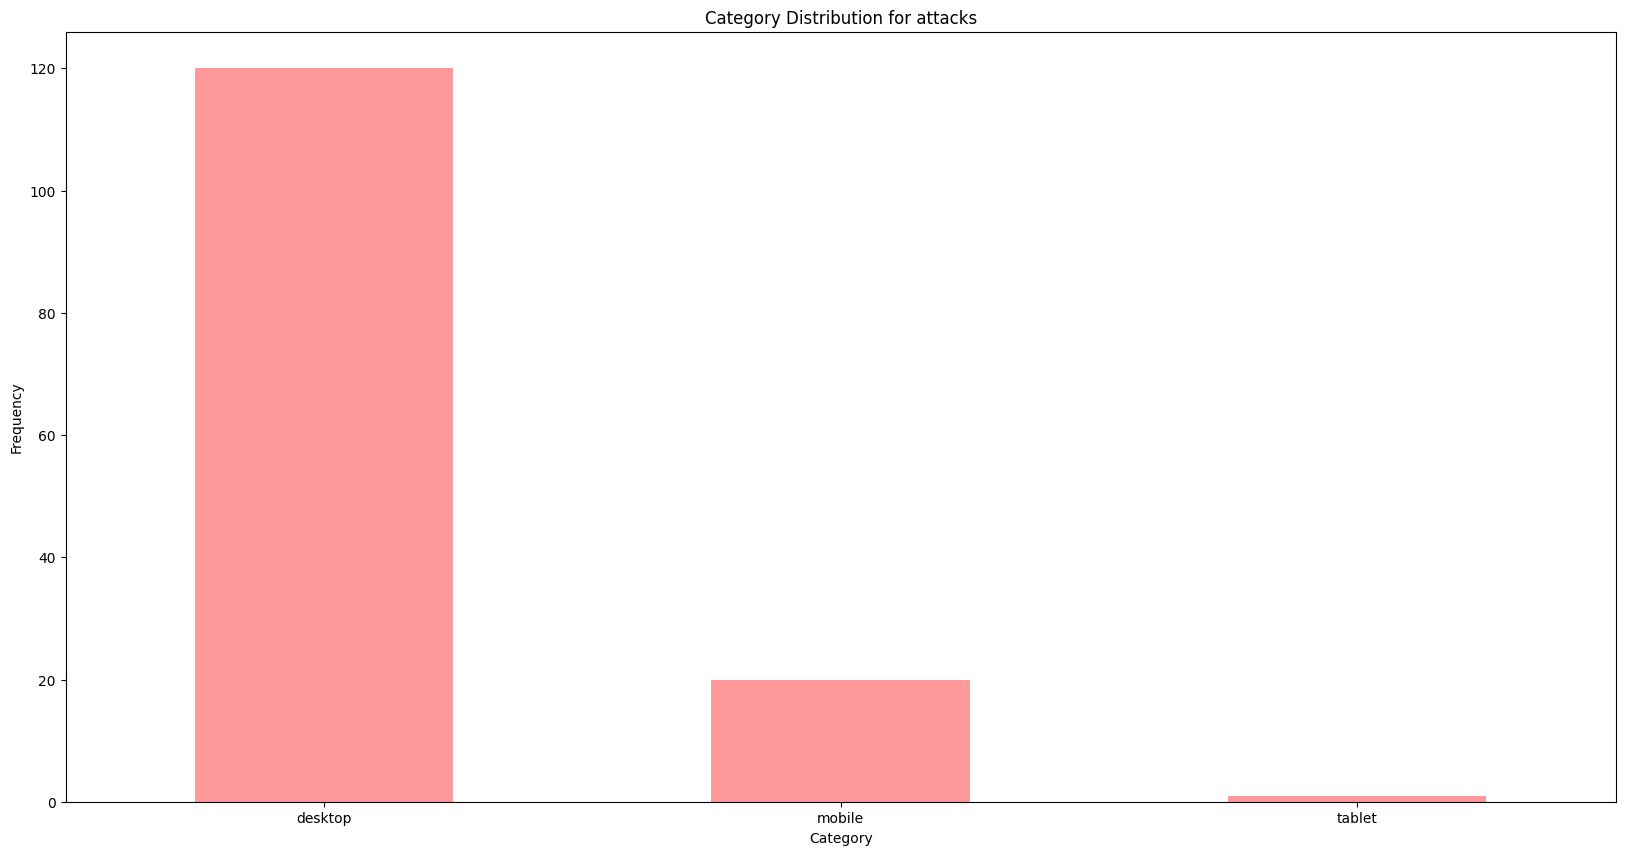

In [261]:
category_counts = data[data['is_account_takeover']==True]["device"].value_counts()
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='#FF9999')
plt.title('Category Distribution for attacks')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

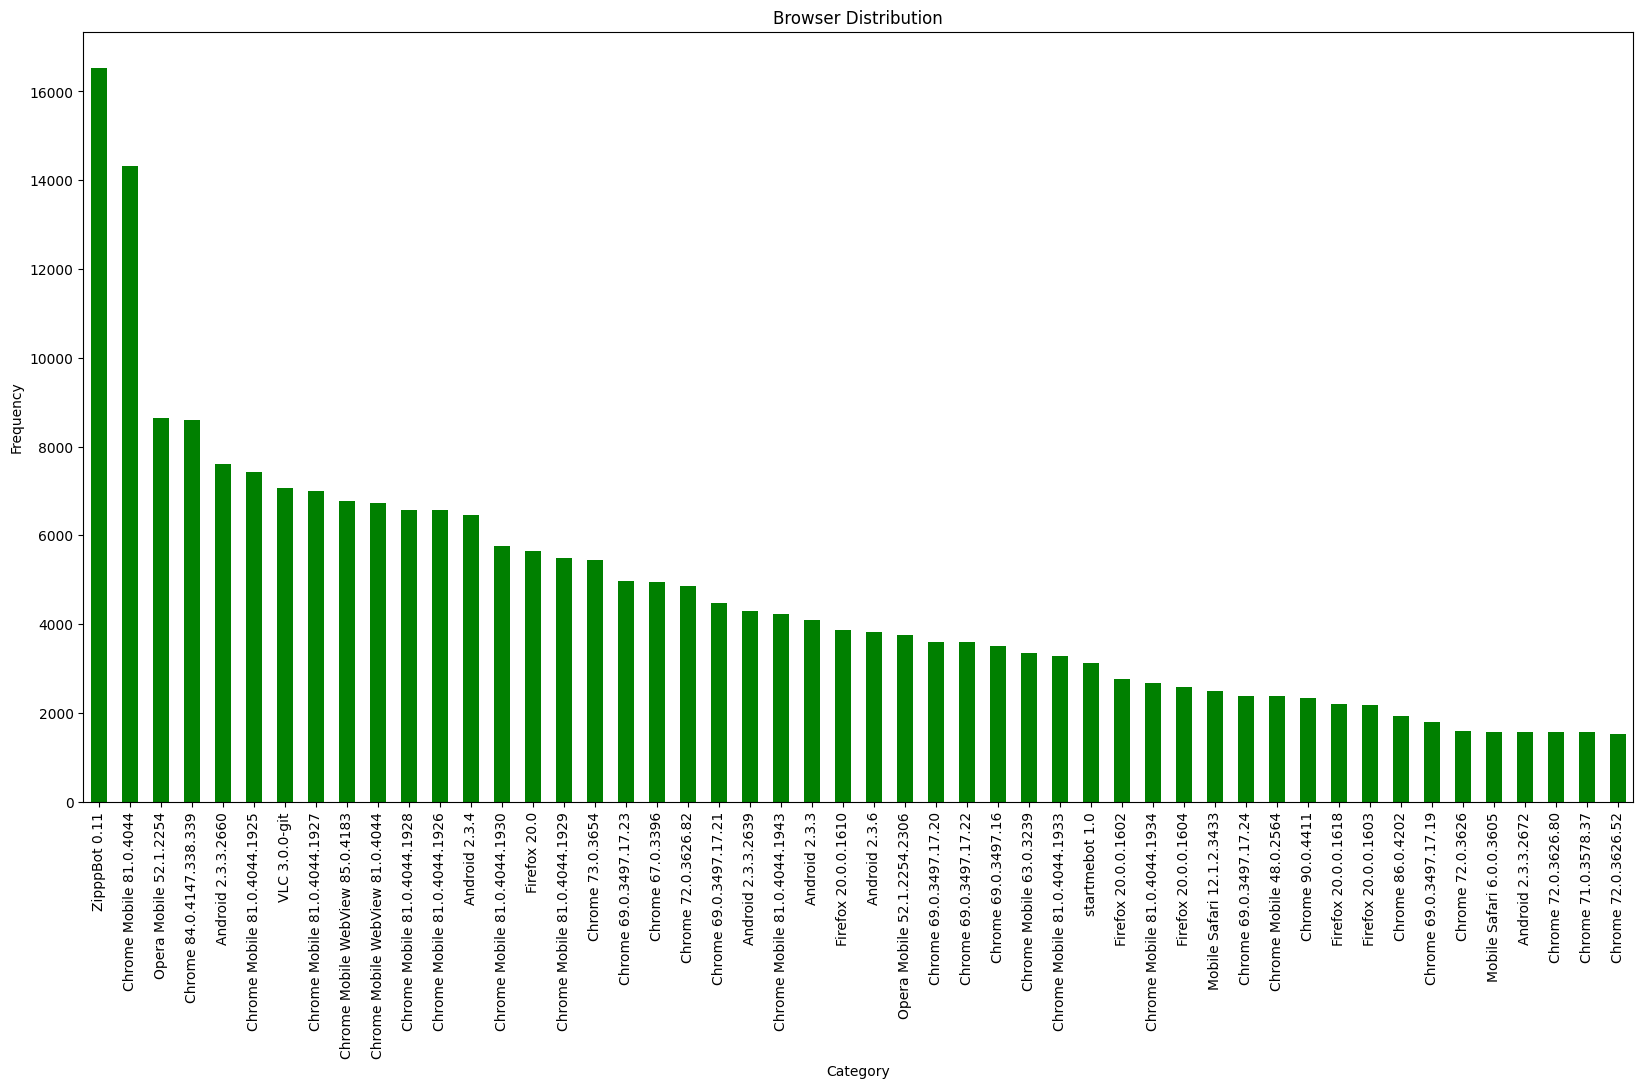

In [262]:
category_counts = data["browser"].value_counts().head(50)
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='green')
plt.title('Browser Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

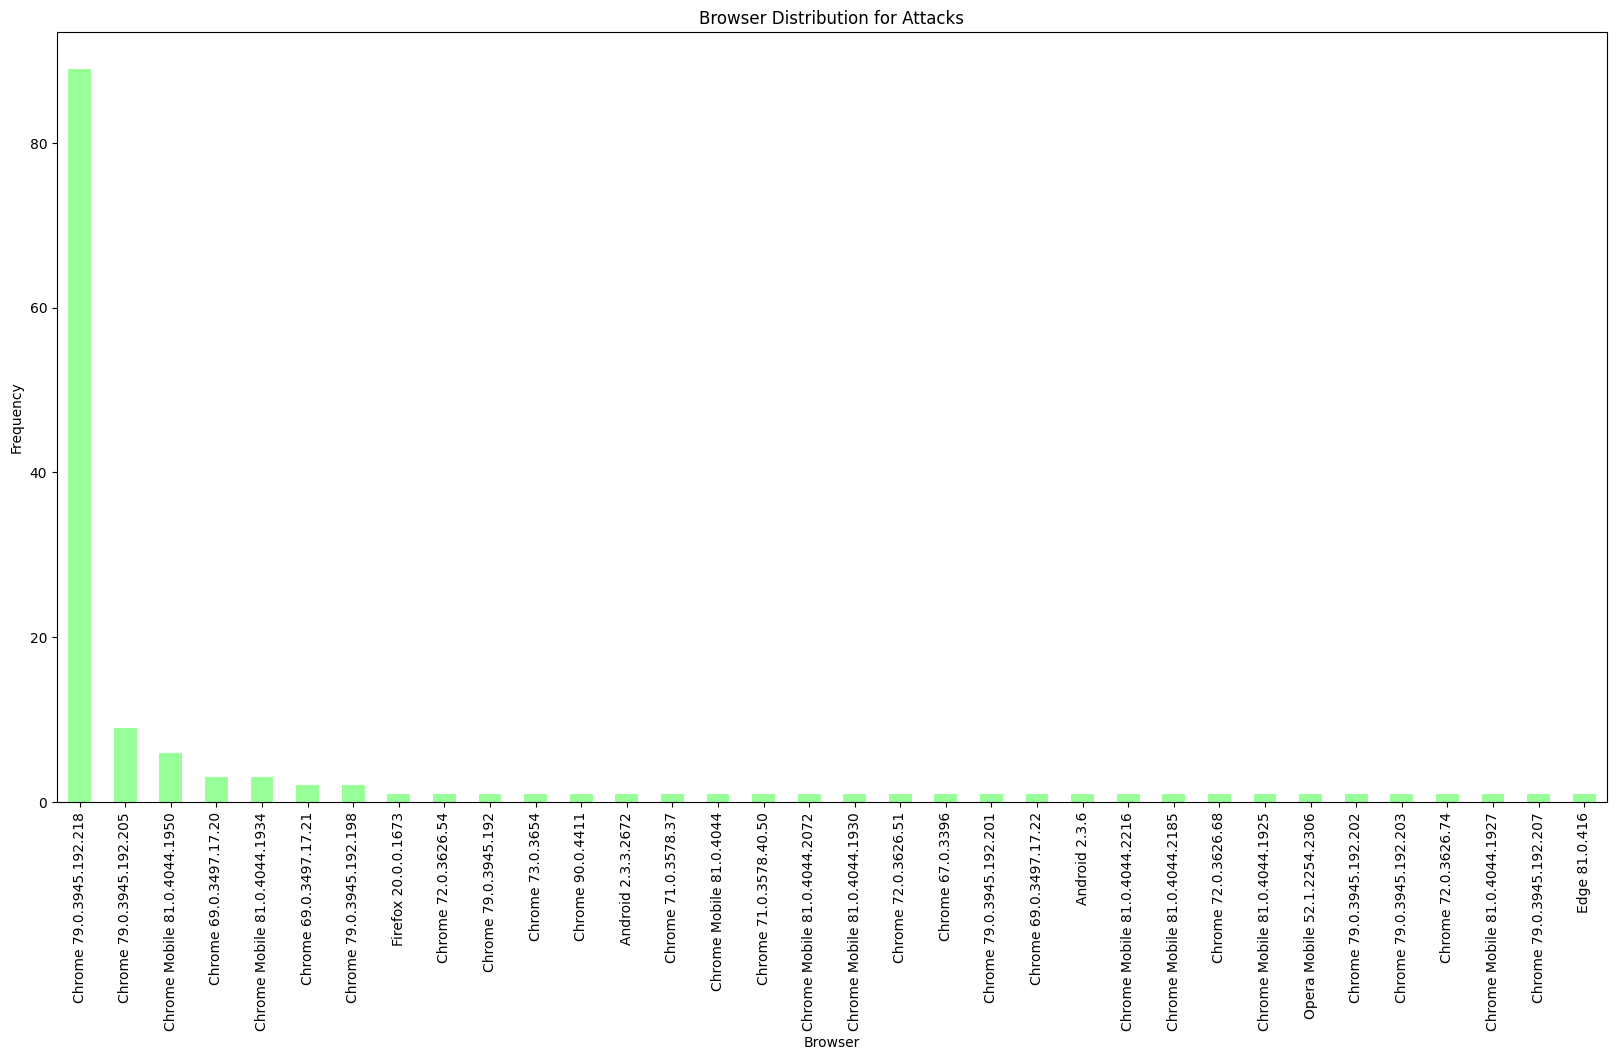

In [263]:
category_counts = data[data['is_account_takeover']==True]["browser"].value_counts().head(50)
plt.figure(figsize=(20, 10))
category_counts.plot(kind='bar', color='#99FF99')
plt.title('Browser Distribution for Attacks')
plt.xlabel('Browser')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

## Geographical Data

In [264]:
import plotly.express as px

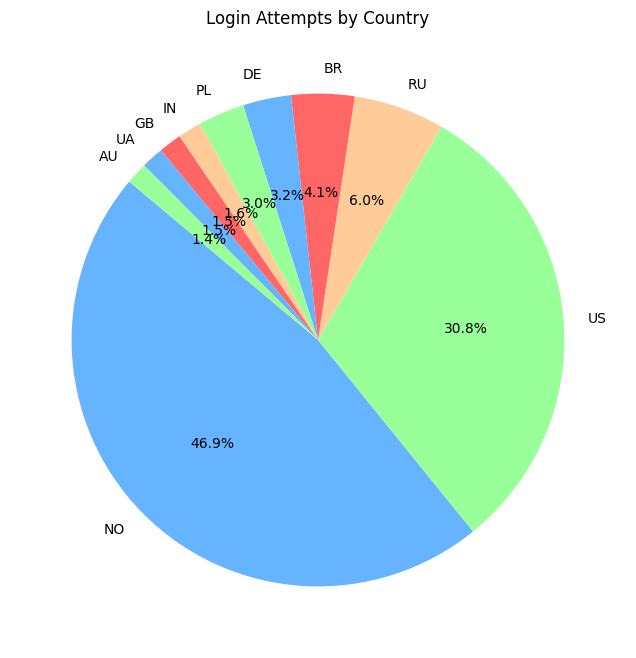

In [265]:
country_counts = data['country'].value_counts().head(10)

plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99','#ff6666'])
plt.title('Login Attempts by Country')
plt.show()

In [266]:
attack_data = data[data["is_account_takeover"] == True][['country']]
normal_connections = data[data["is_account_takeover"] != True][['country']]
normal_connections

,country
0,NO
1,NO
2,NO
3,PL
4,CH
...,...
312829,BR
312830,DE
312831,IN
312832,BR


In [267]:
iso2_to_iso3_map = {
    'AD': 'AND', 'AE': 'ARE', 'AF': 'AFG', 'AG': 'ATG', 'AI': 'AIA', 'AL': 'ALB',
    'AM': 'ARM', 'AO': 'AGO', 'AR': 'ARG', 'AS': 'ASM', 'AT': 'AUT', 'AU': 'AUS',
    'AW': 'ABW', 'AX': 'ALA', 'AZ': 'AZE', 'BA': 'BHS', 'BB': 'BRB', 'BD': 'BGD',
    'BE': 'BEL', 'BF': 'BFA', 'BG': 'BGR', 'BH': 'BHR', 'BI': 'BDI', 'BJ': 'BEN',
    'BL': 'BLM', 'BM': 'BMU', 'BN': 'BRN', 'BO': 'BOL', 'BQ': 'BES', 'BR': 'BRA',
    'BS': 'BHS', 'BT': 'BTN', 'BV': 'BVT', 'BW': 'BWA', 'BY': 'BLR', 'BZ': 'BLZ',
    'CA': 'CAN', 'CC': 'CCK', 'CD': 'COD', 'CF': 'CAF', 'CG': 'COG', 'CH': 'CHE',
    'CI': 'CIV', 'CK': 'COK', 'CL': 'CHL', 'CM': 'CMR', 'CN': 'CHN', 'CO': 'COL',
    'CR': 'CRI', 'CU': 'CUB', 'CV': 'CPV', 'CW': 'CUW', 'CX': 'CXR', 'CY': 'CYP',
    'CZ': 'CZE', 'DE': 'DEU', 'DJ': 'DJI', 'DK': 'DNK', 'DM': 'DMA', 'DO': 'DOM',
    'DZ': 'DZA', 'EC': 'ECU', 'EE': 'EST', 'EG': 'EGY', 'EH': 'ESH', 'ER': 'ERI',
    'ES': 'ESP', 'ET': 'ETH', 'FI': 'FIN', 'FJ': 'FJI', 'FM': 'FSM', 'FO': 'FRO',
    'FR': 'FRA', 'GA': 'GAB', 'GB': 'GBR', 'GD': 'GRD', 'GE': 'GEO', 'GF': 'GUF',
    'GG': 'GGY', 'GH': 'GHA', 'GI': 'GIB', 'GL': 'GRL', 'GM': 'GMB', 'GN': 'GIN',
    'GP': 'GLP', 'GQ': 'GNQ', 'GR': 'GRC', 'GT': 'GTM', 'GU': 'GUM', 'GW': 'GNB',
    'GY': 'GUY', 'HK': 'HKG', 'HM': 'HMD', 'HN': 'HND', 'HR': 'HRV', 'HT': 'HTI',
    'HU': 'HUN', 'ID': 'IDN', 'IE': 'IRL', 'IL': 'ISR', 'IM': 'IMN', 'IN': 'IND',
    'IO': 'IOT', 'IQ': 'IRQ', 'IR': 'IRN', 'IS': 'ISL', 'IT': 'ITA', 'JE': 'JEY',
    'JM': 'JAM', 'JO': 'JOR', 'JP': 'JPN', 'KE': 'KEN', 'KG': 'KGZ', 'KH': 'KHM',
    'KI': 'KIR', 'KM': 'COM', 'KN': 'KNA', 'KP': 'PRK', 'KR': 'KOR', 'KW': 'KWT',
    'KY': 'CYM', 'KZ': 'KAZ', 'LA': 'LAO', 'LB': 'LBN', 'LC': 'LCA', 'LI': 'LIE',
    'LK': 'LKA', 'LR': 'LBR', 'LS': 'LSO', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA',
    'LY': 'LBY', 'MA': 'MAR', 'MC': 'MCO', 'MD': 'MDA', 'ME': 'MNE', 'MF': 'MAF',
    'MG': 'MDG', 'MH': 'MHL', 'MK': 'MKD', 'ML': 'MLI', 'MM': 'MMR', 'MN': 'MNG',
    'MO': 'MAC', 'MP': 'MNP', 'MQ': 'MTQ', 'MR': 'MRT', 'MS': 'MSR', 'MT': 'MLT',
    'MU': 'MUS', 'MV': 'MDV', 'MW': 'MWI', 'MX': 'MEX', 'MY': 'MYS', 'MZ': 'MOZ',
    'NA': 'NAM', 'NC': 'NCL', 'NE': 'NER', 'NF': 'NFK', 'NG': 'NGA', 'NI': 'NIC',
    'NL': 'NLD', 'NO': 'NOR', 'NP': 'NPL', 'NR': 'NRU', 'NU': 'NIU', 'NZ': 'NZL',
    'OM': 'OMN', 'PA': 'PAN', 'PE': 'PER', 'PF': 'PYF', 'PG': 'PNG', 'PH': 'PHL',
    'PK': 'PAK', 'PL': 'POL', 'PM': 'SPM', 'PN': 'PCN', 'PR': 'PRI', 'PT': 'PRT',
    'PW': 'PLW', 'PY': 'PRY', 'QA': 'QAT', 'RE': 'REU', 'RO': 'ROU', 'RS': 'SRB',
    'RU': 'RUS', 'RW': 'RWA', 'SA': 'SAU', 'SB': 'SLB', 'SC': 'SYC', 'SD': 'SDN',
    'SE': 'SWE', 'SG': 'SGP', 'SH': 'SHN', 'SI': 'SVN', 'SJ': 'SJM', 'SK': 'SVK',
    'SL': 'SLE', 'SM': 'SMR', 'SN': 'SEN', 'SO': 'SOM', 'SR': 'SUR', 'SS': 'SSD',
    'ST': 'STP', 'SV': 'SLV', 'SX': 'SXM', 'SY': 'SYR', 'SZ': 'SWZ', 'TC': 'TCA',
    'TD': 'TCD', 'TF': 'ATF', 'TG': 'TGO', 'TH': 'THA', 'TJ': 'TJK', 'TK': 'TKL',
    'TL': 'TLS', 'TM': 'TKM', 'TN': 'TUN', 'TO': 'TON', 'TR': 'TUR', 'TT': 'TTO',
    'TV': 'TUV', 'TZ': 'TZA', 'UA': 'UKR', 'UG': 'UGA', 'UM': 'UMI', 'US': 'USA',
    'UY': 'URY', 'UZ': 'UZB', 'VA': 'VAT', 'VC': 'VCT', 'VE': 'VEN', 'VG': 'VGB',
    'VI': 'VIR', 'VN': 'VNM', 'VU': 'VUT', 'WF': 'WLF', 'WS': 'WSM', 'YE': 'YEM',
    'YT': 'MYT', 'ZA': 'ZAF', 'ZM': 'ZMB', 'ZW': 'ZWE'
}

def iso2_to_iso3(iso2):
    return iso2_to_iso3_map.get(iso2.upper(), iso2)


attack_data['country'] = data['country'].apply(iso2_to_iso3)
normal_connections['country'] = data['country'].apply(iso2_to_iso3)

In [268]:
attack_counts = attack_data.groupby("country").size().reset_index(name="Attack Count")
normal_connections = normal_connections.groupby("country").size().reset_index(name="Connections Count")

In [269]:
attack_counts.sort_values(by='Attack Count' , ascending=False)

,country,Attack Count
13,ROU,79
11,NOR,10
1,BRA,9
2,CAN,9
6,IDN,9
7,ITA,7
5,DNK,5
3,CHL,3
8,LVA,3
4,CZE,2


In [270]:
fig = px.choropleth(
    attack_counts,
    locations="country",
    locationmode="ISO-3",
    color="Attack Count",
    title="Number of Attacks by Country",
    color_continuous_scale="Reds"
)
fig.update_layout(
    width=1200,
    height=600
)
fig.show()

In [271]:
normal_connections.sort_values(by='Connections Count' , ascending=False)

,country,Connections Count
125,NOR,132215
175,USA,86793
142,RUS,16812
25,BRA,11636
44,DEU,8913
...,...,...
105,MAF,1
166,TLS,1
161,TCD,1
155,SUR,1


In [272]:
fig = px.choropleth(
    normal_connections,
    locations="country",
    locationmode="ISO-3",
    color="Connections Count",
    title="Map of Normal Connections by Country",
    color_continuous_scale="Blues"
)
fig.update_layout(
    width=1200,
    height=600
)
fig.show()

## Missing Data

In [273]:
data.isnull().sum()

index                       0
timestamp                   0
id                          0
rtt_ms                 300094
ip                          0
country                     0
region                    482
city                      104
asn                         0
user_agent                  0
browser                     0
os                          0
device                     14
login_success               0
is_attack_ip                0
is_account_takeover         0
dtype: int64

In [274]:
missing_rtt = data['rtt_ms'].isnull().sum() / len(data) * 100
missing_rtt

np.float64(95.92755263174719)

In [275]:
data = data.drop(columns=['rtt_ms', 'region', 'city'])

In [276]:
data['device'].fillna(data['device'].mode()[0])

0         desktop
1          mobile
2          mobile
3         desktop
4         desktop
           ...   
312829     mobile
312830    unknown
312831     mobile
312832    desktop
312833    desktop
Name: device, Length: 312834, dtype: object

## Time Data

In [277]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

In [278]:
data['hour'] = data['timestamp'].dt.hour
data['day'] = data['timestamp'].dt.day_name()
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,51.175.224.92,NO,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.21,Mac OS X 10.14.6,desktop,False,False,False,18,Tuesday
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,80.232.87.86,NO,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,True,False,False,11,Friday
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,84.234.232.132,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox 20.0.0.1602,iOS 11.2.6,mobile,False,False,False,16,Saturday
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,185.19.116.76,PL,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 79.0.3945.192.201,Chrome OS 5978.98.0,desktop,False,False,False,14,Monday
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,10.0.181.224,CH,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 72.0.3626.82,Mac OS X 11.6.3,desktop,False,False,False,10,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,10.1.43.51,BR,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1937,iOS 13.4,mobile,False,False,False,22,Saturday
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,10.4.138.195,DE,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,False,False,15,Friday
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,10.0.106.46,IN,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1929,iOS 11.2.6,mobile,False,False,False,2,Wednesday
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,10.0.181.225,BR,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 84.0.4147.338.339,Mac OS X 11.6.3,desktop,False,False,False,12,Thursday


In [279]:
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

data['time'] = data['hour'].apply(categorize_time_of_day)
data


,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,51.175.224.92,NO,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.21,Mac OS X 10.14.6,desktop,False,False,False,18,Tuesday,Evening
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,80.232.87.86,NO,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,True,False,False,11,Friday,Morning
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,84.234.232.132,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox 20.0.0.1602,iOS 11.2.6,mobile,False,False,False,16,Saturday,Afternoon
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,185.19.116.76,PL,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 79.0.3945.192.201,Chrome OS 5978.98.0,desktop,False,False,False,14,Monday,Afternoon
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,10.0.181.224,CH,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 72.0.3626.82,Mac OS X 11.6.3,desktop,False,False,False,10,Wednesday,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,10.1.43.51,BR,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1937,iOS 13.4,mobile,False,False,False,22,Saturday,Night
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,10.4.138.195,DE,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,False,False,False,15,Friday,Afternoon
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,10.0.106.46,IN,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1929,iOS 11.2.6,mobile,False,False,False,2,Wednesday,Night
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,10.0.181.225,BR,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 84.0.4147.338.339,Mac OS X 11.6.3,desktop,False,False,False,12,Thursday,Afternoon


In [280]:
data['is_account_takeover'] = data['is_account_takeover'].astype(int)
data['is_attack_ip'] = data['is_attack_ip'].astype(int) #!!!!!!!!!!!!! inspect this one later
data['login_success'] = data['login_success'].astype(int)

In [281]:
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,51.175.224.92,NO,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.21,Mac OS X 10.14.6,desktop,0,0,0,18,Tuesday,Evening
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,80.232.87.86,NO,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,1,0,0,11,Friday,Morning
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,84.234.232.132,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox 20.0.0.1602,iOS 11.2.6,mobile,0,0,0,16,Saturday,Afternoon
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,185.19.116.76,PL,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 79.0.3945.192.201,Chrome OS 5978.98.0,desktop,0,0,0,14,Monday,Afternoon
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,10.0.181.224,CH,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 72.0.3626.82,Mac OS X 11.6.3,desktop,0,0,0,10,Wednesday,Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,10.1.43.51,BR,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1937,iOS 13.4,mobile,0,0,0,22,Saturday,Night
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,10.4.138.195,DE,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,0,0,0,15,Friday,Afternoon
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,10.0.106.46,IN,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1929,iOS 11.2.6,mobile,0,0,0,2,Wednesday,Night
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,10.0.181.225,BR,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 84.0.4147.338.339,Mac OS X 11.6.3,desktop,0,0,0,12,Thursday,Afternoon


## Categorical Data

In [282]:
categorical_columns = data.select_dtypes(include=['object'])
categorical_columns.columns

Index(['ip', 'country', 'user_agent', 'browser', 'os', 'device', 'day',
       'time'],
      dtype='object')

### IP Address and ASN

In [283]:
data['ip'].value_counts().sort_values(ascending=False)

ip
10.3.205.197      4403
23.137.225.33     3114
10.3.205.196      2484
10.3.205.195      2380
10.3.205.194      1800
                  ... 
83.243.128.53        1
80.202.201.0         1
80.211.250.102       1
185.51.20.30         1
62.73.224.31         1
Name: count, Length: 164470, dtype: int64

In [284]:
ip_counts = data['ip'].value_counts()
data['ip_connection_count'] = data['ip'].map(ip_counts)

In [285]:
data['asn'].value_counts().sort_values(ascending=False)

asn
29695     81446
393398    73169
15599     16525
41164     14266
262582    13985
          ...  
197790        1
27847         1
506981        1
500841        1
505599        1
Name: count, Length: 3237, dtype: int64

In [286]:
asn_counts = data['asn'].value_counts()
data['asn_count'] = data['asn'].map(asn_counts)
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time,ip_connection_count,asn_count
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,51.175.224.92,NO,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 69.0.3497.17.21,Mac OS X 10.14.6,desktop,0,0,0,18,Tuesday,Evening,1,81446
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,80.232.87.86,NO,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera Mobile 52.1.2254,Android 13.0,mobile,1,0,0,11,Friday,Morning,1,3650
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,84.234.232.132,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox 20.0.0.1602,iOS 11.2.6,mobile,0,0,0,16,Saturday,Afternoon,1,81446
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,185.19.116.76,PL,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 79.0.3945.192.201,Chrome OS 5978.98.0,desktop,0,0,0,14,Monday,Afternoon,10,1166
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,10.0.181.224,CH,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 72.0.3626.82,Mac OS X 11.6.3,desktop,0,0,0,10,Wednesday,Morning,364,13985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,10.1.43.51,BR,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome Mobile 81.0.4044.1937,iOS 13.4,mobile,0,0,0,22,Saturday,Night,1,1866
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,10.4.138.195,DE,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC 3.0.0-git,Other,unknown,0,0,0,15,Friday,Afternoon,568,568
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,10.0.106.46,IN,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome Mobile 81.0.4044.1929,iOS 11.2.6,mobile,0,0,0,2,Wednesday,Night,1,1276
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,10.0.181.225,BR,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome 84.0.4147.338.339,Mac OS X 11.6.3,desktop,0,0,0,12,Thursday,Afternoon,358,13985


### Country

In [287]:
data['country'].value_counts().sort_values(ascending=False)

country
NO    132225
US     86793
RU     16812
BR     11645
DE      8913
       ...  
YE         1
TD         1
BV         1
MF         1
AG         1
Name: count, Length: 188, dtype: int64

In [288]:
k = 6
top_k_countries = data["country"].value_counts().nlargest(k).index
data["country"] = data["country"].apply(lambda x: x if x in top_k_countries else "other")

In [289]:
data['country'].value_counts().sort_values(ascending=False)

country
NO       132225
US        86793
other     47911
RU        16812
BR        11645
DE         8913
PL         8535
Name: count, dtype: int64

### Browser

In [290]:
data['browser'].value_counts().sort_values(ascending=False)

browser
ZipppBot 0.11                   16520
Chrome Mobile 81.0.4044         14332
Opera Mobile 52.1.2254           8651
Chrome 84.0.4147.338.339         8606
Android 2.3.3.2660               7618
                                ...  
Android 2.3.3.2664                  1
Android 2.0.0.2455                  1
Chrome Mobile 81.0.4044.2143        1
Firefox 20.0.0.1737                 1
Chrome 75.0.3770.136                1
Name: count, Length: 1333, dtype: int64

In [291]:
data['browser'] = data['browser'].apply(lambda x : x.split()[0])

In [292]:
k = 8
top_k_browsers = data["browser"].value_counts().nlargest(k).index
data["browser"] = data["browser"].apply(lambda x: x if x in top_k_browsers else "other")

In [293]:
data['browser'].value_counts().sort_values(ascending=False)

browser
Chrome        197361
Android        31447
Firefox        28289
ZipppBot       16520
Opera          14961
other           9548
VLC             7068
Mobile          4526
startmebot      3114
Name: count, dtype: int64

## OS

In [294]:
data['os'] = data['os'].apply(lambda x : x.split()[0])

In [295]:
data['os'].value_counts().sort_values(ascending=False)

os
iOS           113318
Android        83062
Mac            64563
Other          28587
Chrome          9861
Windows         5404
Chromecast      5032
KaiOS           2622
Ubuntu            87
BlackBerry        82
Fedora            72
PROSONIC          39
MeeGo             37
134               14
Gentoo            13
Red               11
Linux              9
Tizen              6
Roku               6
Slackware          3
NetBSD             2
DIGIHOME           1
GoogleTV           1
Sailfish           1
Web0S              1
Name: count, dtype: int64

In [296]:
k = 8
top_k_os = data["os"].value_counts().nlargest(k).index
data["os"] = data["os"].apply(lambda x: x if x in top_k_os else "Other")

In [297]:
data['os'].value_counts().sort_values(ascending=False)

os
iOS           113318
Android        83062
Mac            64563
Other          28972
Chrome          9861
Windows         5404
Chromecast      5032
KaiOS           2622
Name: count, dtype: int64

## Device

In [298]:
data['device'].value_counts().sort_values(ascending=False)

device
mobile     196587
desktop     79654
bot         20106
unknown      8606
tablet       7867
Name: count, dtype: int64

In [299]:
data

,index,timestamp,id,ip,country,asn,user_agent,browser,os,device,login_success,is_attack_ip,is_account_takeover,hour,day,time,ip_connection_count,asn_count
0,18772391,2020-10-20 18:59:35.329,-4324475583306591935,51.175.224.92,NO,29695,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome,Mac,desktop,0,0,0,18,Tuesday,Evening,1,81446
1,7930838,2020-05-22 11:20:46.696,-9158722628840289273,80.232.87.86,NO,25400,Mozilla/5.0 (Linux; U; Android 13.0; i phone X...,Opera,Android,mobile,1,0,0,11,Friday,Morning,1,3650
2,28390433,2021-01-23 16:31:55.322,4432628985308499079,84.234.232.132,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Firefox,iOS,mobile,0,0,0,16,Saturday,Afternoon,1,81446
3,3090501,2020-03-16 14:24:46.628,-4324475583306591935,185.19.116.76,PL,49528,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome,Chrome,desktop,0,0,0,14,Monday,Afternoon,10,1166
4,29828901,2021-02-10 10:40:40.931,-4324475583306591935,10.0.181.224,other,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome,Mac,desktop,0,0,0,10,Wednesday,Morning,364,13985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,11034609,2020-07-04 22:22:08.091,-4324475583306591935,10.1.43.51,BR,500194,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Chrome,iOS,mobile,0,0,0,22,Saturday,Night,1,1866
312830,25178766,2020-12-25 15:16:06.779,-4324475583306591935,10.4.138.195,DE,500608,VLC/3.0.0-git LibVLC/3.0.0-git,VLC,Other,unknown,0,0,0,15,Friday,Afternoon,568,568
312831,13215789,2020-08-05 02:35:55.789,-4324475583306591935,10.0.106.46,other,45916,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_6 lik...,Chrome,iOS,mobile,0,0,0,2,Wednesday,Night,1,1276
312832,14264354,2020-08-20 12:10:26.089,-4324475583306591935,10.0.181.225,BR,262582,Mozilla/5.0 (Macintosh; Intel Mac OS X 11_6_3...,Chrome,Mac,desktop,0,0,0,12,Thursday,Afternoon,358,13985


In [300]:
filtered_columns = ['day',
                    'time',
                    'ip_connection_count',
                    'asn_count',
                    'country',
                    'os',
                    'browser',
                    'device',
                    'login_success',
                   # 'is_attack_ip',
                    'is_account_takeover'
                    ]
data_filtered = data[filtered_columns]
data_filtered

,day,time,ip_connection_count,asn_count,country,os,browser,device,login_success,is_account_takeover
0,Tuesday,Evening,1,81446,NO,Mac,Chrome,desktop,0,0
1,Friday,Morning,1,3650,NO,Android,Opera,mobile,1,0
2,Saturday,Afternoon,1,81446,NO,iOS,Firefox,mobile,0,0
3,Monday,Afternoon,10,1166,PL,Chrome,Chrome,desktop,0,0
4,Wednesday,Morning,364,13985,other,Mac,Chrome,desktop,0,0
...,...,...,...,...,...,...,...,...,...,...
312829,Saturday,Night,1,1866,BR,iOS,Chrome,mobile,0,0
312830,Friday,Afternoon,568,568,DE,Other,VLC,unknown,0,0
312831,Wednesday,Night,1,1276,other,iOS,Chrome,mobile,0,0
312832,Thursday,Afternoon,358,13985,BR,Mac,Chrome,desktop,0,0


### Encoding Categorical Data

In [301]:
hot_encoded = ['os', 'browser', 'device', 'time', 'day', 'country']
data_filtered = pd.get_dummies(data_filtered, columns=hot_encoded)
data_filtered = data_filtered.astype(int)

In [302]:
data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312834 entries, 0 to 312833
Data columns (total 44 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   ip_connection_count  312834 non-null  int64
 1   asn_count            312834 non-null  int64
 2   login_success        312834 non-null  int64
 3   is_account_takeover  312834 non-null  int64
 4   os_Android           312834 non-null  int64
 5   os_Chrome            312834 non-null  int64
 6   os_Chromecast        312834 non-null  int64
 7   os_KaiOS             312834 non-null  int64
 8   os_Mac               312834 non-null  int64
 9   os_Other             312834 non-null  int64
 10  os_Windows           312834 non-null  int64
 11  os_iOS               312834 non-null  int64
 12  browser_Android      312834 non-null  int64
 13  browser_Chrome       312834 non-null  int64
 14  browser_Firefox      312834 non-null  int64
 15  browser_Mobile       312834 non-null  int64
 16  br

### The problem of imbalanced data

In [303]:
value_counts = data_filtered['is_account_takeover'].value_counts()
value_counts

is_account_takeover
0    312693
1       141
Name: count, dtype: int64

In [304]:
data_filtered

,ip_connection_count,asn_count,login_success,is_account_takeover,os_Android,os_Chrome,os_Chromecast,os_KaiOS,os_Mac,os_Other,...,day_Thursday,day_Tuesday,day_Wednesday,country_BR,country_DE,country_NO,country_PL,country_RU,country_US,country_other
0,1,81446,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,1,3650,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,81446,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,10,1166,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,364,13985,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,1,1866,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
312830,568,568,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
312831,1,1276,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
312832,358,13985,0,0,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [305]:
attack_percentage = (value_counts.get(1, 0) / value_counts.sum()) * 100
attack_percentage

np.float64(0.04507182723105545)

## Training Model

In [306]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

X = data_filtered.drop(['is_account_takeover'], axis=1)
Y = data_filtered['is_account_takeover']

In [307]:
Y.value_counts()

is_account_takeover
0    312693
1       141
Name: count, dtype: int64

In [308]:
X

,ip_connection_count,asn_count,login_success,os_Android,os_Chrome,os_Chromecast,os_KaiOS,os_Mac,os_Other,os_Windows,...,day_Thursday,day_Tuesday,day_Wednesday,country_BR,country_DE,country_NO,country_PL,country_RU,country_US,country_other
0,1,81446,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
1,1,3650,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,81446,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,10,1166,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,364,13985,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312829,1,1866,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
312830,568,568,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
312831,1,1276,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
312832,358,13985,0,0,0,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0


In [309]:

from imblearn.over_sampling import SMOTE
method = SMOTE(
    sampling_strategy = 1,
    k_neighbors = 5,
    random_state= RANDOM_STATE,
)
X_bal, Y_bal = method.fit_resample(X, Y)

/home/anwar/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.

/home/anwar/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/sklearn/utils/_tags.py:354: FutureWarning:

The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.



In [310]:
Y_bal.value_counts()

is_account_takeover
0    312693
1    312693
Name: count, dtype: int64

In [311]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

model = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(model, X_bal, Y_bal, cv=5)


print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

X_train, X_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Cross-validation scores: [0.99925646 0.99988007 0.9998321  0.99988807 0.99988007]
Mean cross-validation score: 0.9997473568178579
Confusion Matrix:
[[62283    18]
 [   16 62761]]


In [312]:
from imblearn.over_sampling import SMOTENC
method = SMOTENC(
    sampling_strategy = 0.5,
    k_neighbors = 5,
    random_state= RANDOM_STATE,
    categorical_features = list(range(2, X.shape[1]))
)

X_bal, Y_bal = method.fit_resample(X, Y)

/home/anwar/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning:

`BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.

/home/anwar/PycharmProjects/JupyterProject/.venv/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning:

`BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.



In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

model = RandomForestClassifier(random_state=42)

skf = StratifiedKFold(n_splits=5)

scorings = ['accuracy', 'r2', 'roc_auc_ovr', 'recall']

cv_results = cross_validate(
    model,
    X_bal,
    Y_bal,
    cv=skf,
    scoring=scorings,
    return_train_score=False
)

for scoring in scorings:
    print(f"Cross-validation scores for {scoring}: {cv_results[f'test_{scoring}']}")
    print(f"Mean cross-validation score for {scoring}: {cv_results[f'test_{scoring}'].mean()}")


Cross-validation scores for accuracy: [0.99882739 0.99943502 0.9993604  0.99943502 0.99940303]
Mean cross-validation score for accuracy: 0.9992921699706414
Cross-validation scores for r2: [0.99472324 0.99745756 0.99712177 0.9974576  0.99731363]
Mean cross-validation score for r2: 0.9968147588845356
Cross-validation scores for roc_auc_ovr: [0.99940627 0.9997927  0.99974399 0.99975279 0.99976299]
Mean cross-validation score for roc_auc_ovr: 0.9996917502045658
Cross-validation scores for recall: [0.99830503 0.99971217 0.99996802 0.99990406 0.99993604]
Mean cross-validation score for recall: 0.9995650650544539


In [314]:
X_train, X_test, y_train, y_test = train_test_split(X_bal, Y_bal, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[62482    62]
 [   13 31251]]


In [316]:
print(y_test.value_counts())

is_account_takeover
0    62544
1    31264
Name: count, dtype: int64
